# **Chapter 16.1b - Machine Learning Practicum**

## Using Harmonizome Datasets to Predict Gene Function

The Harmonizome resource developed by the Ma'ayan Lab can be used to perform Machine Learning task to predict novel functions for genes and proteins.

To access the data, you can download the data from http://harmonizome.cloud or to use the [Harmonizome api](http://amp.pharm.mssm.edu/Harmonizome/documentation).

For now you can download and extract the needed data file manually. For this example, the gene_attribute_matrix from the Cancer Cell Line Encyclopidia dataset and from the DISEASES Text-mining Gene-Disease Assocation Evidence Scores dataset are used.

In [48]:
# Ensure all necessary dependencies are installed
%pip install numpy sklearn pandas scipy xgboost plotly[express] supervenn matplotlib

# Import all required modules for this notebook
import numpy as np
import sklearn as sk
import sklearn.decomposition, sklearn.manifold, sklearn.ensemble
import pandas as pd
import xgboost as xgb
import plotly.express as px
from supervenn import supervenn
from matplotlib import pyplot as plt
from IPython.display import display

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


**[DISEASES Curated Gene-Disease Assocation Evidence Scores](https://maayanlab.cloud/Harmonizome/dataset/DISEASES+Curated+Gene-Disease+Assocation+Evidence+Scores)**

DISEASES contains associations between genes anad diseases which were manually curated from literature.

**Original Data**
- The original data before it was processed by Harmonizome can be found at <https://diseases.jensenlab.org/Downloads>

**Citations**
- [Pletscher-Frankild, S et al. (2015) DISEASES: text mining and data integration of disease-gene associations. Methods. 74:83-9.](http://www.ncbi.nlm.nih.gov/pubmed/25484339)

In [2]:
labels_name = 'DISEASES Curated Gene-Disease Associations'
labels = pd.read_table('https://maayanlab.cloud/static/hdfs/harmonizome/data/jensendiseasecurated/gene_attribute_matrix.txt.gz', header=[0, 1, 2], index_col=[0, 1, 2], encoding='latin1', compression='gzip')
labels

#                             hemangioblastoma von hippel-lindau disease  \
#                                    DOID:5241                DOID:14175   
GeneSym                                     na                        na   
SNAP29 ENSP00000215730 9342                0.0                       0.0   
TRPV3  ENSP00000301365 162514              0.0                       0.0   
AAGAB  ENSP00000261880 79719               0.0                       0.0   
CTSC   ENSP00000227266 1075                0.0                       0.0   
KRT6C  ENSP00000252250 286887              0.0                       0.0   
...                                        ...                       ...   
LZTFL1 ENSP00000296135 54585               0.0                       0.0   
IFT27  ENSP00000343593 11020               0.0                       0.0   
HDAC8  ENSP00000362674 55869               0.0                       0.0   
INPP5E ENSP00000360777 56623               0.0                       0.0   
TRIM32 ENSP00000363095 22954               0.0                       0.0   

#                             hemangioma cell type benign neoplasm  \
#                               DOID:255              DOID:0060084   
GeneSym                               na                        na   
SNAP29 ENSP00000215730 9342          0.0                       0.0   
TRPV3  ENSP00000301365 162514        0.0                       0.0   
AAGAB  ENSP00000261880 79719         0.0                       0.0   
CTSC   ENSP00000227266 1075          0.0                       0.0   
KRT6C  ENSP00000252250 286887        0.0                       0.0   
...                                  ...                       ...   
LZTFL1 ENSP00000296135 54585         0.0                       0.0   
IFT27  ENSP00000343593 11020         0.0                       0.0   
HDAC8  ENSP00000362674 55869         0.0                       0.0   
INPP5E ENSP00000360777 56623         0.0                       0.0   
TRIM32 ENSP00000363095 22954         0.0                       0.0   

#                             benign neoplasm polycythemia  \
#                                DOID:0060072    DOID:8432   
GeneSym                                    na           na   
SNAP29 ENSP00000215730 9342               0.0          0.0   
TRPV3  ENSP00000301365 162514             0.0          0.0   
AAGAB  ENSP00000261880 79719              0.0          0.0   
CTSC   ENSP00000227266 1075               0.0          0.0   
KRT6C  ENSP00000252250 286887             0.0          0.0   
...                                       ...          ...   
LZTFL1 ENSP00000296135 54585              0.0          0.0   
IFT27  ENSP00000343593 11020              0.0          0.0   
HDAC8  ENSP00000362674 55869              0.0          0.0   
INPP5E ENSP00000360777 56623              0.0          0.0   
TRIM32 ENSP00000363095 22954              0.0          0.0   

#                             primary polycythemia  \
#                                       DOID:10780   
GeneSym                                         na   
SNAP29 ENSP00000215730 9342                    0.0   
TRPV3  ENSP00000301365 162514                  0.0   
AAGAB  ENSP00000261880 79719                   0.0   
CTSC   ENSP00000227266 1075                    0.0   
KRT6C  ENSP00000252250 286887                  0.0   
...                                            ...   
LZTFL1 ENSP00000296135 54585                   0.0   
IFT27  ENSP00000343593 11020                   0.0   
HDAC8  ENSP00000362674 55869                   0.0   
INPP5E ENSP00000360777 56623                   0.0   
TRIM32 ENSP00000363095 22954                   0.0   

#                             organ system benign neoplasm  \
#                                             DOID:0060085   
GeneSym                                                 na   
SNAP29 ENSP00000215730 9342                            0.0   
TRPV3  ENSP00000301365 162514                          0.0   
AAGAB  ENSP0000026

**[GEO Signatures of Differentially Expressed Genes for Gene Perturbations](https://maayanlab.cloud/Harmonizome/dataset/GEO+Signatures+of+Differentially+Expressed+Genes+for+Gene+Perturbations)**

The Gene Expression Omnibus (GEO) contains data from many experiments, this particular dataset contains rich information about the relationships between genes by measuring the expression of genes when a given gene is knocked out, over expressed, or mutated.

**Original Data**
- Can be accessed on GEO at <https://www.ncbi.nlm.nih.gov/geo/>.

**Citations**
- [Barrett, T et al. (2013) NCBI GEO: archive for functional genomics data sets--update. Nucleic Acids Res. 41:D991-5.](http://www.ncbi.nlm.nih.gov/pubmed/23193258)
- [Edgar, R et al. (2002) Gene Expression Omnibus: NCBI gene expression and hybridization array data repository. Nucleic Acids Res. 30:207-10.](http://www.ncbi.nlm.nih.gov/pubmed/11752295)

In [3]:
X_name = 'GEO Gene Perturbagens'
data = pd.read_table('https://maayanlab.cloud/static/hdfs/harmonizome/data/geogene/gene_attribute_matrix.txt.gz', header=[0, 1, 2], index_col=[0, 1, 2], encoding='latin1', compression='gzip')
data

#                 NIX_Deficiency_GDS2630_160_mouse_spleen  \
#                                                     NIX   
GeneSym                                                na   
RPL7P52 na 646912                                     0.0   
ZNF731P na 729806                                     0.0   
MED15   na 51586                                      0.0   
ZIM2    na 23619                                      0.0   
ABCA11P na 79963                                      0.0   
...                                                   ...   
GGT7    na 2686                                       0.0   
HAUS7   na 55559                                      0.0   
PSPN    na 5623                                       0.0   
GALK2   na 2585                                       0.0   
PHF8    na 23133                                      0.0   

#                 NIX_Deficiency_GDS2630_655_mouse_Spleen  \
#                                                     NIX   
GeneSym                                                na   
RPL7P52 na 646912                                     0.0   
ZNF731P na 729806                                     0.0   
MED15   na 51586                                      0.0   
ZIM2    na 23619                                      0.0   
ABCA11P na 79963                                      0.0   
...                                                   ...   
GGT7    na 2686                                       0.0   
HAUS7   na 55559                                      0.0   
PSPN    na 5623                                       0.0   
GALK2   na 2585                                       0.0   
PHF8    na 23133                                      0.0   

#                 AIRE_KO_GDS2274_246_mouse_Medullary thymic epithelial cells (with high CD80 expression)  \
#                                                                                                    AIRE   
GeneSym                                                                                                na   
RPL7P52 na 646912                                                0.0                                        
ZNF731P na 729806                                                0.0                                        
MED15   na 51586                                                 0.0                                        
ZIM2    na 23619                                                 0.0                                        
ABCA11P na 79963                                                 0.0                                        
...                                                              ...                                        
GGT7    na 2686                                                  0.0                                        
HAUS7   na 55559                                                 0.0                                        
PSPN    na 5623                                                  0.0                                        
GALK2   na 2585                                                  0.0                                        
PHF8    na 23133                                                 0.0                                        

#                 PDX1_KO_GDS4348_360_mouse_Proximal small intestine  \
#                                                               PDX1   
GeneSym                                                           na   
RPL7P52 na 646912                                                0.0   
ZNF731P na 729806                                                0.0   
MED15   na 51586                                                 0.0   
ZIM2    na 23619                                                 0.0   
ABCA11P na 79963                                                 0.0   
...                                                              ...   
GGT7    na 2686                                                  0.0   
HAUS7   na 55559                           

Using the literature curated diseases associated with genes, and the relationships gene have with one another we expect to be able to identify additional genes, not yet annotated as such, which should be associated with a given disease.

In [4]:
labels.sum().sort_values().iloc[-20:]

#                                        #             GeneSym
developmental disorder of mental health  DOID:0060037  na          220.0
specific developmental disorder          DOID:0060038  na          220.0
eye disease                              DOID:5614     na          231.0
eye and adnexa disease                   DOID:1492     na          231.0
globe disease                            DOID:1242     na          231.0
disease of mental health                 DOID:150      na          240.0
neurodegenerative disease                DOID:1289     na          249.0
autosomal genetic disease                DOID:0050739  na          269.0
inherited metabolic disorder             DOID:655      na          272.0
monogenic disease                        DOID:0050177  na          298.0
sensory system disease                   DOID:0050155  na          300.0
cancer                                   DOID:162      na          326.0
disease of cellular proliferation        DOID:14566    na    

Let's consider "eye diseases" since it seems we might be able to get a sufficient amount of genes annotated with this disease term.

In [5]:
y_name = f"Eye Diseases from {labels_name}"
# Find all labels in the DISEASES matrix columns which contain the string "eye"
labels.columns.levels[0][labels.columns.levels[0].str.contains('eye')]

Index(['eye and adnexa disease', 'eye disease'], dtype='object', name='#')

In [6]:
# Subset the DISEASES label matrix, selecting only the eye columns
eye_labels = labels.loc[:, pd.IndexSlice[labels.columns.levels[0][labels.columns.levels[0].str.contains('eye')], :, :]]
eye_labels

#                             eye and adnexa disease eye disease
#                                          DOID:1492   DOID:5614
GeneSym                                           na          na
SNAP29 ENSP00000215730 9342                      0.0         0.0
TRPV3  ENSP00000301365 162514                    0.0         0.0
AAGAB  ENSP00000261880 79719                     0.0         0.0
CTSC   ENSP00000227266 1075                      0.0         0.0
KRT6C  ENSP00000252250 286887                    0.0         0.0
...                                              ...         ...
LZTFL1 ENSP00000296135 54585                     0.0         0.0
IFT27  ENSP00000343593 11020                     0.0         0.0
HDAC8  ENSP00000362674 55869                     0.0         0.0
INPP5E ENSP00000360777 56623                     0.0         0.0
TRIM32 ENSP00000363095 22954                     0.0         0.0

[2252 rows x 2 columns]

In [7]:
# Collapse the matrix into a single vector indexed by the gene symbols (level=0)
#  using 1 if any of the columns contain 1, otherwise 0
y = eye_labels.groupby(level=0).any().any(axis=1).astype(int)
display(y)
# report the count of each value (0/1)
y.value_counts()

AAAS      0
AAGAB     0
AARS      0
AARS2     0
AASS      0
         ..
ZNF513    1
ZNF521    0
ZNF592    0
ZNF711    0
ZNF81     0
Length: 2252, dtype: int64

0    2021
1     231
dtype: int64

y represents labels of genes known to be associated with an eye disease while 0 means it is *unknown*. We can see that there are very few genes known to be associated with eye disease compared to unknown.

It's now time to prepare the "data" matrix from GEO Knockout/Knockdown experiments.

In [8]:
# This collapses the multi index on row and column which will be easier to work
#  with. since these are all unique we can use first without losing information,
#  we can verify this by noticing that the shape remains the same after this operation.
X = data.groupby(level=0).first().T.groupby(level=0).first().T
display(X)
display(data.shape)
display(X.shape)

#          A2BAR_Deficiency_GDS3662_520_mouse_Heart  \
1060P11.3                                       0.0   
A1BG                                            0.0   
A1BG-AS1                                        0.0   
A1CF                                            0.0   
A2M                                             0.0   
...                                             ...   
ZYG11A                                          0.0   
ZYG11B                                         -1.0   
ZYX                                             0.0   
ZZEF1                                           0.0   
ZZZ3                                            0.0   

#          ABCA1_OE_GDS2303_189_mouse_LDL receptor-deficient livers  \
1060P11.3                                                0.0          
A1BG                                                     0.0          
A1BG-AS1                                                 0.0          
A1CF                                                     0.0          
A2M                                                      0.0          
...                                                      ...          
ZYG11A                                                   0.0          
ZYG11B                                                   0.0          
ZYX                                                      0.0          
ZZEF1                                                    0.0          
ZZZ3                                                     0.0          

#          ACADM_KO_GDS4546_512_mouse_liver  \
1060P11.3                               0.0   
A1BG                                    0.0   
A1BG-AS1                                0.0   
A1CF                                    0.0   
A2M                                     1.0   
...                                     ...   
ZYG11A                                  0.0   
ZYG11B                                  0.0   
ZYX                                     0.0   
ZZEF1                                   0.0   
ZZZ3                                    0.0   

#          ACHE_OE_GDS891_241_mouse_Prefrontal cortex  \
1060P11.3                                         0.0   
A1BG                                              0.0   
A1BG-AS1                                          0.0   
A1CF                                              0.0   
A2M                                               0.0   
...                                               ...   
ZYG11A                                            0.0   
ZYG11B                                            0.0   
ZYX                                               0.0   
ZZEF1                                             0.0   
ZZZ3                                              0.0   

#          ADNP_Deficiency - NULL MUTATION_GDS2540_691_mouse_E9 embryos - Heterozygous mutant  \
1060P11.3                                                0.0                                    
A1BG                                                     0.0                                    
A1BG-AS1                                                 0.0                                    
A1CF                                                     0.0                                    
A2M                                                      0.0                                    
...                                                      ...                                    
ZYG11A                                                   0.0                                    
ZYG11B                                                   0.0                                    
ZYX                                                      0.0                                    
ZZEF1                                                    0.0                                    
ZZZ3                                                     0.0                                    

#          ADNP_Deficiency - NULL MUTATION_GDS2540_692_mouse_E9 embryos

(22021, 739)

(22021, 739)

One common "discovery" step to do is to perform dimensionality reduction into 2 or 3 dimensions to get a broad sense of the data. These dimensionality reduction techniques will attempt to maximally express the variance in the data (PCA) or the relationships between points (t-SNE/UMAP).

In [36]:
pca = sk.decomposition.PCA()
pca.fit(X.T)
X_pca = pd.DataFrame(
  pca.transform(X.T),
  columns=[f"PC-{i} ({r*100:.3f}%)" for i, r in enumerate(pca.explained_variance_ratio_, start=1)],
  index=X.columns,
)
fig = px.scatter(
  X_pca,
  hover_data=[X_pca.index],
  x=X_pca.columns[0], y=X_pca.columns[1],
)
fig

The PCA here is slightly challenging to interpret. This is likely because the principal components are expressing a pretty small amount of variance at fractions of a percent. This won't always be the case but is in this dataset which seems to have a high inherent dimensionality.

In [35]:
tsne = sk.manifold.TSNE(perplexity=10, metric='cosine')
X_tsne = pd.DataFrame(
  tsne.fit_transform(X.T),
  columns=["t-SNE-1", "t-SNE-2"],
  index=X.columns,
)
fig = px.scatter(
  X_tsne,
  hover_data=[X_tsne.index],
  x=X_tsne.columns[0], y=X_tsne.columns[1],
)
fig.update_layout(xaxis_showticklabels=False, yaxis_showticklabels=False)
fig

The t-SNE visualization shown above illustrates why PCA was difficult to interpret; hovering over the points you'll see that each small cluster of points contains samples with common themes, either the same tissue/cell line or experiment. In effect, each cluster of samples has its own variance.

We're now getting ready to use `X` and `y` for machine learning. We'll first need to align the two, that-is make operate on a common, shared set of genes. We'll use SuperVenn to visualize the overlap between genes in the labels and in the underlying data we're using for machine learning.

/home/u8sand/.local/lib/python3.10/site-packages/supervenn/_plots.py:402: UserWarning:

Parameters figsize and dpi of supervenn() are deprecated and will be removed in a future version.
Instead of this:
    supervenn(sets, figsize=(8, 5), dpi=90)
Please either do this:
    plt.figure(figsize=(8, 5), dpi=90)
    supervenn(sets)
or plot into an existing axis by passing it as the ax argument:
    supervenn(sets, ax=my_axis)




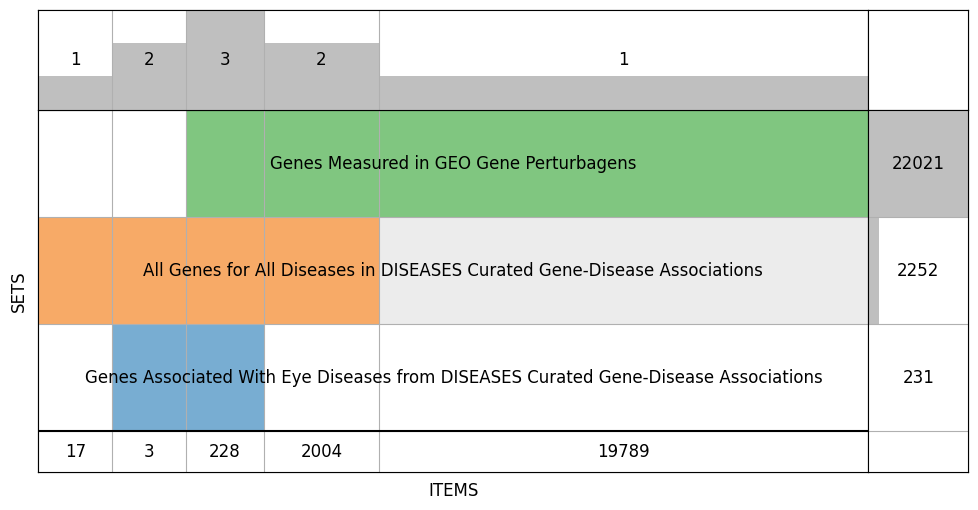

In [38]:
# This shows gene overlap between the labeled genes and the genes in our data
supervenn([
  set(y[y==1].index),
  set(y.index),
  set(X.index),
], [
  f"Genes Associated With {y_name}",
  f"All Genes for All Diseases in {labels_name}",
  f"Genes Measured in {X_name}",
], widths_minmax_ratio=0.15, figsize=(12, 6))

In [39]:
# this matches y's index with X, wherever y doesn't have a gene in x we get an NaN which we'll just assign as 0
X, y = X.align(y, axis=0, join='left')
y = y.fillna(0)
display(X)
display(y)

#          A2BAR_Deficiency_GDS3662_520_mouse_Heart  \
1060P11.3                                       0.0   
A1BG                                            0.0   
A1BG-AS1                                        0.0   
A1CF                                            0.0   
A2M                                             0.0   
...                                             ...   
ZYG11A                                          0.0   
ZYG11B                                         -1.0   
ZYX                                             0.0   
ZZEF1                                           0.0   
ZZZ3                                            0.0   

#          ABCA1_OE_GDS2303_189_mouse_LDL receptor-deficient livers  \
1060P11.3                                                0.0          
A1BG                                                     0.0          
A1BG-AS1                                                 0.0          
A1CF                                                     0.0          
A2M                                                      0.0          
...                                                      ...          
ZYG11A                                                   0.0          
ZYG11B                                                   0.0          
ZYX                                                      0.0          
ZZEF1                                                    0.0          
ZZZ3                                                     0.0          

#          ACADM_KO_GDS4546_512_mouse_liver  \
1060P11.3                               0.0   
A1BG                                    0.0   
A1BG-AS1                                0.0   
A1CF                                    0.0   
A2M                                     1.0   
...                                     ...   
ZYG11A                                  0.0   
ZYG11B                                  0.0   
ZYX                                     0.0   
ZZEF1                                   0.0   
ZZZ3                                    0.0   

#          ACHE_OE_GDS891_241_mouse_Prefrontal cortex  \
1060P11.3                                         0.0   
A1BG                                              0.0   
A1BG-AS1                                          0.0   
A1CF                                              0.0   
A2M                                               0.0   
...                                               ...   
ZYG11A                                            0.0   
ZYG11B                                            0.0   
ZYX                                               0.0   
ZZEF1                                             0.0   
ZZZ3                                              0.0   

#          ADNP_Deficiency - NULL MUTATION_GDS2540_691_mouse_E9 embryos - Heterozygous mutant  \
1060P11.3                                                0.0                                    
A1BG                                                     0.0                                    
A1BG-AS1                                                 0.0                                    
A1CF                                                     0.0                                    
A2M                                                      0.0                                    
...                                                      ...                                    
ZYG11A                                                   0.0                                    
ZYG11B                                                   0.0                                    
ZYX                                                      0.0                                    
ZZEF1                                                    0.0                                    
ZZZ3                                                     0.0                                    

#          ADNP_Deficiency - NULL MUTATION_GDS2540_692_mouse_E9 embryos

1060P11.3    0.0
A1BG         0.0
A1BG-AS1     0.0
A1CF         0.0
A2M          0.0
            ... 
ZYG11A       0.0
ZYG11B       0.0
ZYX          0.0
ZZEF1        0.0
ZZZ3         0.0
Length: 22021, dtype: float64

We consider the problem of predicting whether or not a given gene should be associated with eye disease. Let's start by reserving some of the genes for validation.

In [40]:
# we'll shuffle the data and use 20% of the data for testing & the rest for training
#  stratify ensures we end up with the same proportion of eye/non-eye samples in the split
# using a fixed random state makes this selection reproducable across runs
random_state = 42
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=random_state)

In [94]:
# because of the high class imbalance, we'll "weigh" the negative samples much less than the
#  positive samples so that our model learns in an unbiased way
y_train_distribution = y_train.value_counts()
display(y_train_distribution)
class_weights = (1-y_train_distribution/y_train_distribution.sum()).to_dict()
display(class_weights)
sample_weights = y_train.apply(class_weights.get)
display(sample_weights)

0.0    17434
1.0      182
dtype: int64

{0.0: 0.010331516802906449, 1.0: 0.9896684831970936}

PAPPA2       0.010332
RPA2         0.010332
FZD4         0.989668
NPFFR1       0.010332
LINC00461    0.010332
               ...   
SLC25A47     0.010332
SNX30        0.010332
OPALIN       0.010332
TGFBR1       0.010332
VAT1         0.010332
Length: 17616, dtype: float64

In [57]:
def benchmark_classifier(clf, X_train, y_train, X_test, y_test, sample_weight=None):
  ''' This function 
  '''
  clf = sk.clone(clf)
  # fit the classifier using the train samples, include sample weight when specified to balance imbalanced samples
  clf.fit(X_train.values, y_train.values, sample_weight=sample_weight)
  # obtain the classifier reported prediction probabilities on the training data and also on the test data
  y_train_pred = clf.predict_proba(X_train.values)[:, 1]
  y_test_pred = clf.predict_proba(X_test.values)[:, 1]
  # construct a plot showing ROC, PR & Confusion Matrix for Train and Test
  fig, axes = plt.subplots(2, 3, figsize=(10,8))
  axes = np.array(axes)
  sk.metrics.RocCurveDisplay.from_predictions(y_train, y_train_pred, name='Train', ax=axes[0, 0])
  sk.metrics.PrecisionRecallDisplay.from_predictions(y_train, y_train_pred, name='Train', ax=axes[0, 1])
  sk.metrics.ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred>0.5, ax=axes[0, 2])
  sk.metrics.RocCurveDisplay.from_predictions(y_test, y_test_pred, name='Test', ax=axes[1, 0])
  sk.metrics.PrecisionRecallDisplay.from_predictions(y_test, y_test_pred, name='Test', ax=axes[1, 1])
  sk.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred>0.5, ax=axes[1, 2])
  plt.tight_layout() # recalculate sizing

The following cell benchmarks [scikit-learn's cross-validated logistic regression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html).

A linear regression simply draws a line through the points and solves the equation $$Y=MX+b$$ "learning" the best values for $M$ and $b$ given pairs of $Y$ and $X$.

The Logistic Regression function is a linear regression function of a logit function, defined as $$logistic(x) = \frac{L}{1+e^{-k(x-x_0)}}$$ in practice mapping from $(-\infty,\infty)\rightarrow(0,1)$, this is commonly used to make a regressor into a binary classifier, since the regression predictions become predictions of the probability. Thus the logistic regression *classifier* solve the equation: $$y=logistic(MX+b)$$ it still is learning $M$ and $b$ but now the output $y$ is a probability.

Finally the "CV" in `LogisticRegressionCV` refers to a cross validation estimator. This augmentation of an estimator will perform cross validation (by default, stratified k-fold) to select the best hyperparameters. This means that, in the case that `cv=5` (corresponding to 5-fold cross validation) the learned $M$ and $b$ are chosen by splitting the X into 5 groups and using 4 of them to predict the 5th for all 5 combinations; the $M$ and $b$ which works the best on the unseen segment are chosen for the model.

The sample weights are provided to counteract the fact that our training data is heavily imbalanced with so few positive examples and many more negative examples. Without it, our model will get better accuracy by simply predicting everything to be negative.

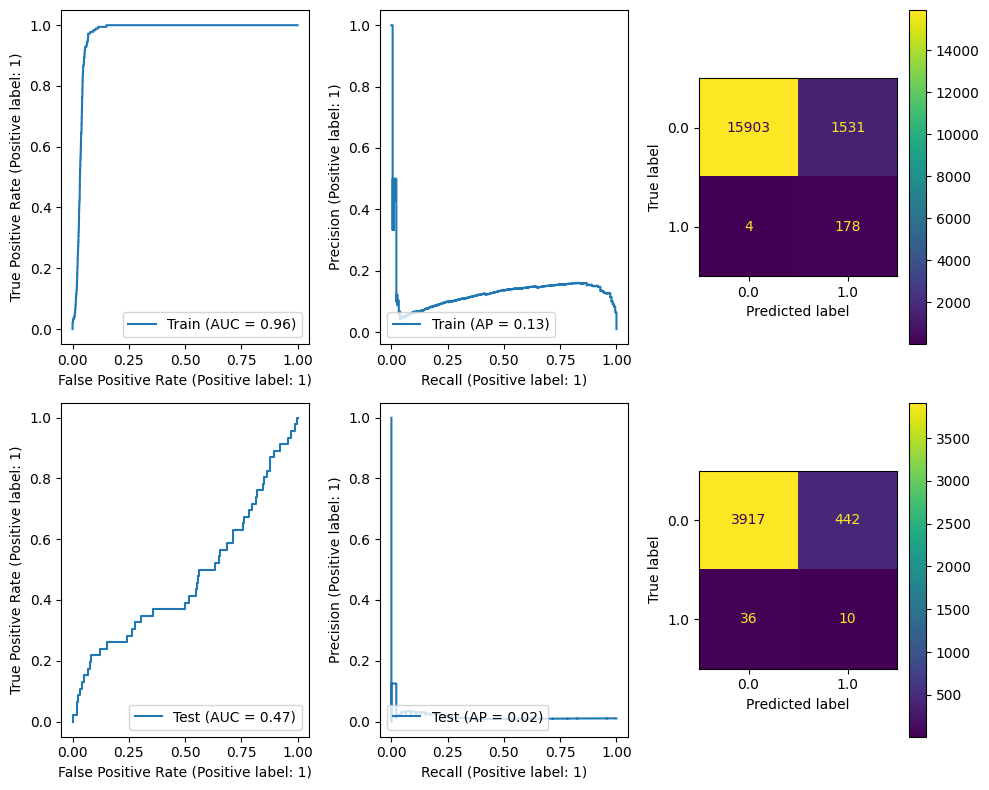

In [75]:
benchmark_classifier(
  sk.linear_model.LogisticRegressionCV(cv=5, max_iter=4000, random_state=random_state),
  X_train, y_train, X_test, y_test, sample_weight=sample_weights,
)

We can see that even a linear model can learn the training data quite well, but it does not generalize spectacularly to the test data.

Next we'll try [scikit-learn's RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).

A Random Forest Classifier fits many decision trees (`n_estimators`) on various subsamples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

A Random Forest will train many Decision Trees and use randomness in those tree parameters; each tree will make its own prediction and the random forest will average those predictions.

A Decision Tree is a set of piecewise constant decision rules inferred from the data to maximally separate the samples. For more information, [see scikit-learn's user guide on decision trees](https://scikit-learn.org/stable/modules/tree.html).

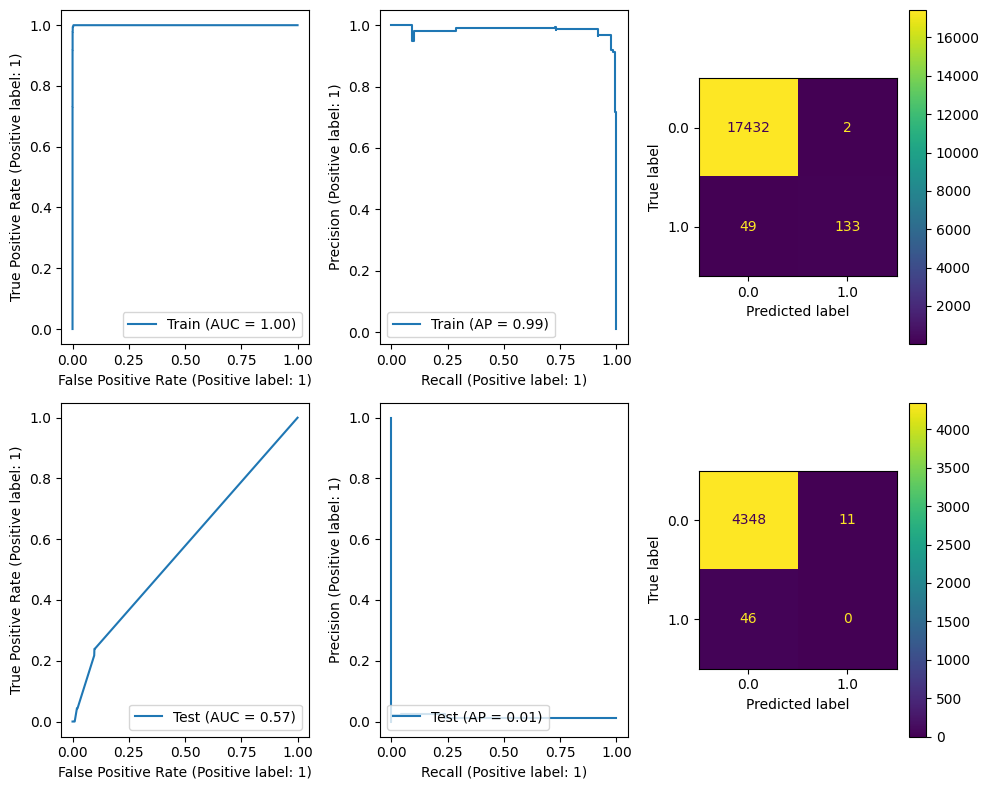

In [76]:
benchmark_classifier(
  sk.ensemble.RandomForestClassifier(n_estimators=10, random_state=random_state),
  X_train, y_train, X_test, y_test,
  sample_weight=sample_weights,
)

Looking at the results, we can see that we can almost perfectly fit to the training data but performance on the test data is quite bad. We can see from the Confusion Matrix that apart from a few samples we just predict 0 on the test data.

Finally we'll try [XGBoost](https://xgboost.readthedocs.io/en/stable/).

This algorithm is commonly used in Kaggle Competitions and is a often very fast and very good at getting performance. It is a distributed gradient boosted tree algorithm which in short is a bit like Random Forest but the ensemble predictions are parameterized and the whole thing is optimized by gradient descent. More information about this can be found in [XGBoost's Tutorial Section](https://xgboost.readthedocs.io/en/stable/tutorials/model.html).

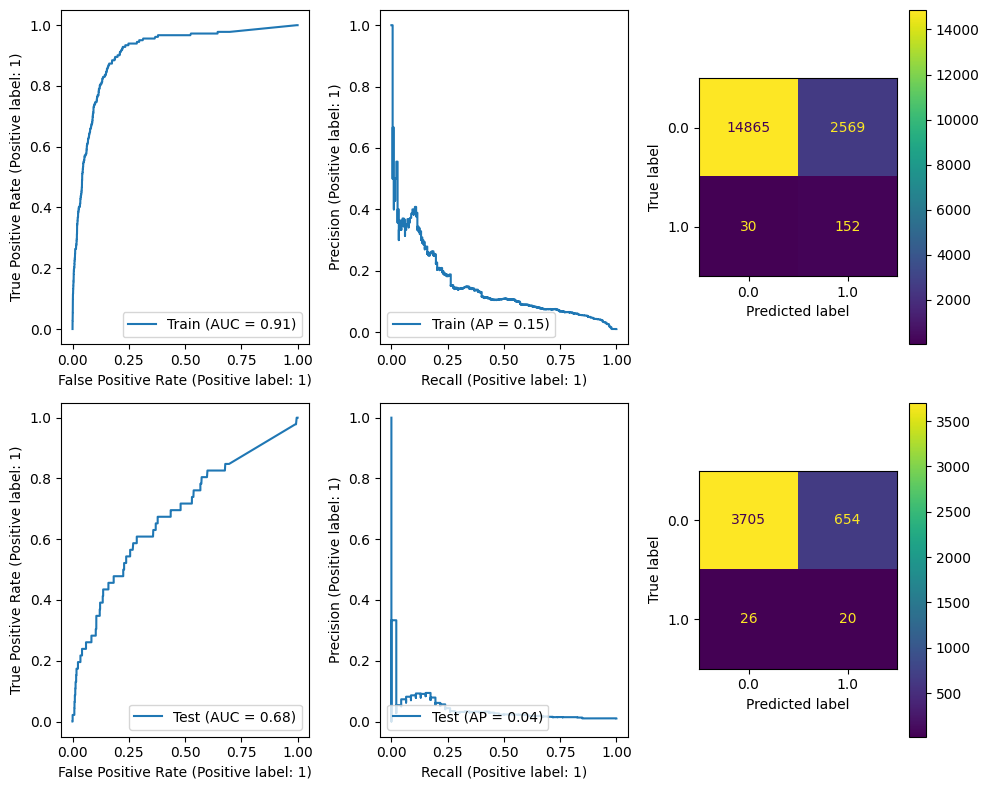

In [77]:
benchmark_classifier(
  xgb.XGBClassifier(random_state=random_state),
  X_train, y_train, X_test, y_test,
  sample_weight=sample_weights,
)

And apparently, even without tuning, XGBoost doesn't do bad at all. It's able to recover roughly half of the test labels and there are many candidates to investigate.

Lets see how we export results from these models.

Predictions will be genes which our model is still assigning a high priority despite our training, this we hope is due to the fact that these genes share characteristics in the data that genes we know to be related to eye disease.

Though we are benchmarking on the test set the architecture of our model, after we know that we're able to generalize we can use all the data so that our model has more information to work from.

In [92]:
# recompute sample weights on all the data
y_distribution = y.value_counts()
class_weights = (1-y_distribution/y_distribution.sum()).to_dict()
sample_weights = y.apply(class_weights.get)

# train XGB on all the data
model = xgb.XGBClassifier(random_state=random_state)
model.fit(X.values, y.values, sample_weight=sample_weights)

In [95]:
y_pred_proba = model.predict_proba(X.values)[:, 1]
predictions = pd.concat([
  pd.DataFrame(y_pred_proba, columns=['y_pred_proba'], index=X.index),
  y.to_frame('y_true'),
], axis=1).sort_values('y_pred_proba', ascending=False)
novel_predictions = predictions[(predictions['y_pred_proba'] > 0.5) & (predictions['y_true']!=1)]
display(predictions.head())
display(novel_predictions.shape[0])
display(novel_predictions.iloc[:10])

y_pred_proba  y_true
PDE6B        0.995153     1.0
FOS          0.994672     0.0
SOX2         0.992685     1.0
ST6GAL2      0.990135     0.0
CDKN1A       0.982836     0.0

3181

y_pred_proba  y_true
FOS          0.994672     0.0
ST6GAL2      0.990135     0.0
CDKN1A       0.982836     0.0
EPHA7        0.981085     0.0
CTGF         0.980631     0.0
HPGD         0.978051     0.0
TH           0.976438     0.0
LRP1B        0.975008     0.0
MGP          0.972189     0.0
ABHD14A      0.969236     0.0

The output of the model is a prediction probability. We could choose a different cuttoff based on our desired false positive rate by reviewing the ROC & PR curves, or we can consider the simple cutoff of 0.5, considering 0.5 to be a prediction and ordering those predictions by the score the classifier gave.

We can filter out the genes we already know to be associated given that they were part of the original labels and prioritize the predictions. It's important to note that these "probabilities" are simply the scores the model assigned and don't necessarily reflect reality. Though their rankings should be somewhat broadly consistent, they are subject to the stochastic nature of these models meaning that repeated runs may return different top genes.

It would be a good idea to re-run the process several times and look for coherence and also consider that in the model tuning phase along with over/under fitting considerations.